# PreProcessing data


**First step import data**

In [1]:
import pandas as pd
test = pd.read_csv(
    '../input/competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv(
    '../input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv(
    '../input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv(
    '../input/competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv(
    '../input/competitive-data-science-predict-future-sales/item_categories.csv')

# See some outliers

**some items sell too much.**

<AxesSubplot:xlabel='item_cnt_day'>

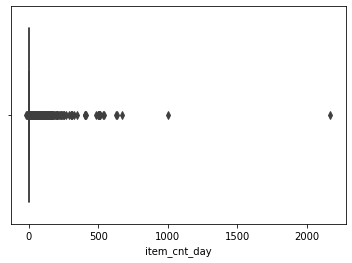

In [3]:
import seaborn as sns
sns.boxplot(x=sales.item_cnt_day)

**some item price are too high.**

<AxesSubplot:xlabel='item_price'>

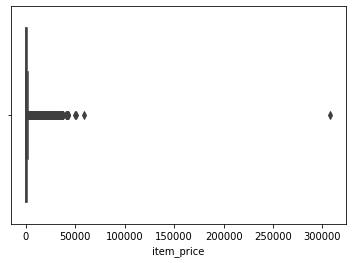

In [4]:
sns.boxplot(x=sales.item_price)

**shop name looks similar.**

In [5]:
print(shops[shops.shop_id.isin([0, 57])]['shop_name'])
print(shops[shops.shop_id.isin([1, 58])]['shop_name'])
print(shops[shops.shop_id.isin([40, 39])]['shop_name'])

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


# Process outliers

In [2]:
train = sales[(sales.item_price < 100000) & (sales.item_price > 0)]
train = train[sales.item_cnt_day < 1001]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [4]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

In [13]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Grouping block number

In [6]:
import numpy as np
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[sales['date_block_num']
                          == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num']
                          == block_num, 'item_id'].unique()
    df.append(
        np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns=index_cols, dtype=np.int32)

# Adding monthly sales accoring to block

In [7]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                        .fillna(0)
                        .clip(0, 20)
                        .astype(np.float16))

In [17]:
df

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0
...,...,...,...,...
10842072,21,7635,33,0.0
10842073,21,7638,33,0.0
10842074,21,7640,33,0.0
10842075,21,7632,33,0.0


# Adding test dataset

In [8]:
# test dataset
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test = test.drop(columns=['ID'])
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0, inplace=True)

# Adding features
* city code feature
* item category feature
* weekend feature
* interaction feature
* lag feature

**adding city code feature**

In [9]:
from sklearn.preprocessing import LabelEncoder

# add city code feature
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]
df = pd.merge(df, shops, on=['shop_id'], how='left')

In [22]:
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part
0,59,22154,0,1.0,30,57.62987,39.87368,2
1,59,2552,0,0.0,30,57.62987,39.87368,2
2,59,2554,0,0.0,30,57.62987,39.87368,2
3,59,2555,0,0.0,30,57.62987,39.87368,2
4,59,2564,0,0.0,30,57.62987,39.87368,2
...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4
11056273,45,16188,34,0.0,19,53.20007,50.15000,4
11056274,45,15757,34,0.0,19,53.20007,50.15000,4
11056275,45,19648,34,0.0,19,53.20007,50.15000,4


**add item category feature**

In [10]:
# add item category feature
map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }

items = pd.merge(items, item_cats, on='item_category_id')

items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]
df = pd.merge(df, items, on=['item_id'], how='left')

In [24]:
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59
...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40


**adding weekend feature**

In [11]:
import calendar
# add weekend feature 
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])

In [27]:
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,4,31
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,4,31
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,4,31
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,4,31
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,5,30
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,5,30
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,5,30
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,5,30


**add interaction feature**

In [12]:
# add interaction feature
# item first appears in which block
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

# items, shop first appear in which block
first_shop_item_buy_block = df[df['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [13]:
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

# item was sold before this block
df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)
 
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8') 

In [14]:
del first_item_block
del first_shop_item_buy_block

In [30]:
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,4,31,1,0
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,4,31,1,0
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,4,31,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,5,30,0,1
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,5,30,0,1
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,5,30,0,1
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,5,30,0,1


# lag feature function

In [15]:
#  add lag feature
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

**adding sales lag**

In [16]:
#Add sales lags for last 3 months
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,4,31,1,0,NaN,NaN,NaN
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0,NaN,NaN,NaN
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0,NaN,NaN,NaN
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,4,31,1,0,NaN,NaN,NaN
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,4,31,1,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,5,30,0,1,1.0,0.0,0.0
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,5,30,0,1,0.0,0.0,NaN
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,5,30,0,1,0.0,0.0,0.0
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,5,30,0,1,0.0,0.0,0.0


**Add avg shop/item price**

In [17]:

index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")

df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,weeknd_count,days_in_month,item_first_interaction,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,4,31,1,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,5,30,0,1,1.0,0.0,0.0,0.0,-1.0,-1.0
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,5,30,0,1,0.0,0.0,NaN,-1.0,-1.0,NaN
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,5,30,0,1,0.0,0.0,0.0,-1.0,-1.0,-1.0
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,5,30,0,1,0.0,0.0,0.0,-1.0,-1.0,-1.0


**Add target encoding for item/city for last 3 months**

In [18]:
item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.drop(['item_loc_target_enc'], axis=1, inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,...,shop_item_sold_before,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,...,1,1.0,0.0,0.0,0.0,-1.0,-1.0,0.5,0.0,0.0
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,...,1,0.0,0.0,NaN,-1.0,-1.0,NaN,0.0,0.0,NaN
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,...,1,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.5,0.0
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,...,1,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0


**Add target encoding for item/shop for last 3 months**

In [19]:
 
item_id_target_mean = df.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_shop_target_enc"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

df['item_shop_target_enc'] = (df['item_shop_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_shop_target_enc')
df.drop(['item_shop_target_enc'], axis=1, inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,...,item_cnt_month_lag_3,item_shop_price_avg_lag_1,item_shop_price_avg_lag_2,item_shop_price_avg_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,...,0.0,0.0,-1.0,-1.0,0.5,0.0,0.0,1.0,0.0,0.0
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,...,NaN,-1.0,-1.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,...,0.0,-1.0,-1.0,-1.0,0.0,0.5,0.0,0.0,0.0,0.0
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,...,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


**For new items add avg category sales for last 3 months**

In [20]:
#For new items add avg category sales for last 3 months
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_cat_avg')
df.drop(['new_item_cat_avg'], axis=1, inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,...,item_shop_price_avg_lag_3,item_loc_target_enc_lag_1,item_loc_target_enc_lag_2,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,...,-1.0,0.5,0.0,0.0,1.0,0.0,0.0,0.518555,0.175903,0.440430
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.033325,0.111633,NaN
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,...,-1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.518555,0.175903,0.440430
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.684082,0.347168,0.631836


**For new items add avg category sales in a separate store for last 3 months**

In [21]:

item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_shop_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code', 'shop_id'], how='left')

df['new_item_shop_cat_avg'] = (df['new_item_shop_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_shop_cat_avg')
df.drop(['new_item_shop_cat_avg'], axis=1, inplace=True)
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,...,item_loc_target_enc_lag_3,item_shop_target_enc_lag_1,item_shop_target_enc_lag_2,item_shop_target_enc_lag_3,new_item_cat_avg_lag_1,new_item_cat_avg_lag_2,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,...,0.0,1.0,0.0,0.0,0.518555,0.175903,0.440430,0.394043,0.086975,0.125000
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,...,NaN,0.0,0.0,NaN,0.033325,0.111633,NaN,0.000000,0.099976,NaN
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,...,0.0,0.0,0.0,0.0,0.518555,0.175903,0.440430,0.394043,0.086975,0.125000
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,...,0.0,0.0,0.0,0.0,0.684082,0.347168,0.631836,0.234009,0.232544,0.258545


**Add sales for the last three months for similar item (item with id = item_id +- 1)**

In [22]:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')
def lag_feature_adv2(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv2']
        shifted['date_block_num'] += i
        shifted['item_id'] += 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv2'] = df[col+'_lag_'+str(i)+'_adv2'].astype('float16')
    return df

df = lag_feature_adv2(df, [1, 2, 3], 'item_cnt_month')
df

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,...,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,item_cnt_month_lag_1_adv2,item_cnt_month_lag_2_adv2,item_cnt_month_lag_3_adv2
0,59,22154,0,1.0,30,57.62987,39.87368,2,11,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59,2552,0,0.0,30,57.62987,39.87368,2,13,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59,2554,0,0.0,30,57.62987,39.87368,2,13,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59,2555,0,0.0,30,57.62987,39.87368,2,13,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,59,2564,0,0.0,30,57.62987,39.87368,2,13,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056272,45,18454,34,0.0,19,53.20007,50.15000,4,13,55,...,0.440430,0.394043,0.086975,0.125000,NaN,NaN,NaN,NaN,1.0,NaN
11056273,45,16188,34,0.0,19,53.20007,50.15000,4,14,64,...,NaN,0.000000,0.099976,NaN,0.0,NaN,NaN,0.0,0.0,NaN
11056274,45,15757,34,0.0,19,53.20007,50.15000,4,13,55,...,0.440430,0.394043,0.086975,0.125000,NaN,NaN,NaN,NaN,NaN,NaN
11056275,45,19648,34,0.0,19,53.20007,50.15000,4,11,40,...,0.631836,0.234009,0.232544,0.258545,NaN,NaN,NaN,NaN,0.0,0.0


**delete first three month data**
**delete shop id 9, 20 from train datset(testdata don't exist)**

In [23]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df = df[(df['shop_id'] != 9)]
df = df[(df['shop_id'] != 20)]
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,city_coord_1,city_coord_2,country_part,item_category_common,item_category_code,...,new_item_cat_avg_lag_3,new_item_shop_cat_avg_lag_1,new_item_shop_cat_avg_lag_2,new_item_shop_cat_avg_lag_3,item_cnt_month_lag_1_adv,item_cnt_month_lag_2_adv,item_cnt_month_lag_3_adv,item_cnt_month_lag_1_adv2,item_cnt_month_lag_2_adv2,item_cnt_month_lag_3_adv2
1122795,25,8092,3,3.0,13,55.75222,37.61556,1,11,40,...,0.293945,1.996094,1.446289,0.891113,7.0,5.0,13.0,0.0,0.0,0.0
1122796,25,7850,3,3.0,13,55.75222,37.61556,1,8,30,...,1.126953,4.867188,0.898438,1.947266,0.0,0.0,0.0,0.0,0.0,3.0
1122797,25,8051,3,3.0,13,55.75222,37.61556,1,14,66,...,0.160645,0.000000,0.416748,1.019531,0.0,0.0,0.0,0.0,0.0,0.0
1122798,25,8088,3,1.0,13,55.75222,37.61556,1,13,55,...,0.208130,1.000000,0.303955,0.534668,0.0,1.0,0.0,0.0,0.0,0.0
1122799,25,8089,3,1.0,13,55.75222,37.61556,1,13,55,...,0.208130,1.000000,0.303955,0.534668,2.0,0.0,3.0,1.0,1.0,0.0


In [24]:
df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'city_code',
       'city_coord_1', 'city_coord_2', 'country_part', 'item_category_common',
       'item_category_code', 'weeknd_count', 'days_in_month',
       'item_first_interaction', 'shop_item_sold_before',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_shop_price_avg_lag_1', 'item_shop_price_avg_lag_2',
       'item_shop_price_avg_lag_3', 'item_loc_target_enc_lag_1',
       'item_loc_target_enc_lag_2', 'item_loc_target_enc_lag_3',
       'item_shop_target_enc_lag_1', 'item_shop_target_enc_lag_2',
       'item_shop_target_enc_lag_3', 'new_item_cat_avg_lag_1',
       'new_item_cat_avg_lag_2', 'new_item_cat_avg_lag_3',
       'new_item_shop_cat_avg_lag_1', 'new_item_shop_cat_avg_lag_2',
       'new_item_shop_cat_avg_lag_3', 'item_cnt_month_lag_1_adv',
       'item_cnt_month_lag_2_adv', 'item_cnt_month_lag_3_adv',
       'item_cnt_month_lag_1_adv2', 'item_cnt_month_lag_2_adv2

In [25]:
df.to_pickle('df.pkl')

# Train model

**prepare dataset**

In [3]:
import pandas as pd
df = pd.read_pickle('df.pkl')
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del df

**train one easy lightgbm**

In [4]:
import lightgbm as lgb
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 8 -1,
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}
feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 30)


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'country_part', 'item_category_code', 'item_category_common']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.572416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3695
[LightGBM] [Info] Number of data points in the train set: 9454927, number of used features: 37


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.295870
Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 1.09691	valid_1's rmse: 0.971915
[100]	training's rmse: 1.01757	valid_1's rmse: 0.909121
[150]	training's rmse: 0.962708	valid_1's rmse: 0.868315
[200]	training's rmse: 0.925171	valid_1's rmse: 0.842061
[250]	training's rmse: 0.898481	valid_1's rmse: 0.826173
[300]	training's rmse: 0.879317	valid_1's rmse: 0.816139
[350]	training's rmse: 0.865078	valid_1's rmse: 0.809429
[400]	training's rmse: 0.853511	valid_1's rmse: 0.805107
[450]	training's rmse: 0.844275	valid_1's rmse: 0.802144
[500]	training's rmse: 0.836309	valid_1's rmse: 0.800055
[550]	training's rmse: 0.830107	valid_1's rmse: 0.798789
[600]	training's rmse: 0.824699	valid_1's rmse: 0.797706
[650]	training's rmse: 0.819329	valid_1's rmse: 0.797257
Early stopping, best iteration is:
[646]	training's rmse: 0.819814	valid_1's rmse: 0.797172


In [6]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('gbm_submission.csv', index=False)